In [1]:
from tools.utils import *
from tools.hom_networks import *

import torch

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# Random
seed = 42

# Model
hidden_channels = 256
num_classes = 6
num_layers = 2
aggr_list = ['sum', 'mean', 'max']
# aggr='mean'
dropout = 0.5
use_skip_connections = True

# Training
batch_size = 32
epochs = 30
decay = 1e-4
lr = 1e-4
maxlr = 3e-4

# Experiments iteration
i = 0

# Preprocess

In [3]:
# Load the ENZYMES dataset
hom_dataset = TUDataset(root='data', name='ENZYMES')                          # This has 3 one-hot encodings
hom_dataset_attr = TUDataset(root='data', name='ENZYMES', use_node_attr=True) # This has 3 one-hot encodings and 18 features

In [4]:
def normalize_enzymes_data(data):
    data = data.clone()
    if hasattr(data, 'x') and data.x is not None:
        x = data.x
        feats = x[:, :18]
        mean = feats.mean(dim=0)
        std = feats.std(dim=0, unbiased=False)
        std[std == 0] = 1.0
        normalized_feats = (feats - mean) / std
        x[:, :18] = normalized_feats
        data.x = x
    return data

# Normalize features
normalized_hom_dataset_attr = [normalize_enzymes_data(hom_data) for hom_data in hom_dataset_attr]

In [5]:
# Create splits
labels = [data.y.item() for data in normalized_hom_dataset_attr]

train_set, temp_set = train_test_split(
    normalized_hom_dataset_attr, 
    test_size=0.3, 
    stratify=labels,
    random_state=seed
    
)

temp_labels = [data.y.item() for data in temp_set]
valid_set, test_set = train_test_split(
    temp_set, 
    test_size=0.5, 
    stratify=temp_labels,
    random_state=seed
)

# train_loader is defined at each experiment for reproducibility
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# 'sum'

Epoch 1/30
Train Loss: 1.7986 | Validation Loss: 1.7927
Train Acc: 0.1929 | Validation Acc: 0.1333
Train F1: 0.1201 | Validation F1: 0.0837

Epoch 2/30
Train Loss: 1.7986 | Validation Loss: 1.7920
Train Acc: 0.1595 | Validation Acc: 0.1444
Train F1: 0.1197 | Validation F1: 0.0613

Epoch 3/30
Train Loss: 1.7940 | Validation Loss: 1.7931
Train Acc: 0.1595 | Validation Acc: 0.1556
Train F1: 0.1379 | Validation F1: 0.0462

Epoch 4/30
Train Loss: 1.7958 | Validation Loss: 1.7920
Train Acc: 0.1643 | Validation Acc: 0.1444
Train F1: 0.1150 | Validation F1: 0.0429

Epoch 5/30
Train Loss: 1.7981 | Validation Loss: 1.7893
Train Acc: 0.1524 | Validation Acc: 0.1667
Train F1: 0.1117 | Validation F1: 0.0485

Epoch 6/30
Train Loss: 1.7889 | Validation Loss: 1.7900
Train Acc: 0.1619 | Validation Acc: 0.1667
Train F1: 0.1260 | Validation F1: 0.0476

Epoch 7/30
Train Loss: 1.7910 | Validation Loss: 1.7845
Train Acc: 0.1786 | Validation Acc: 0.2111
Train F1: 0.1330 | Validation F1: 0.1202

Epoch 8/30
Tr

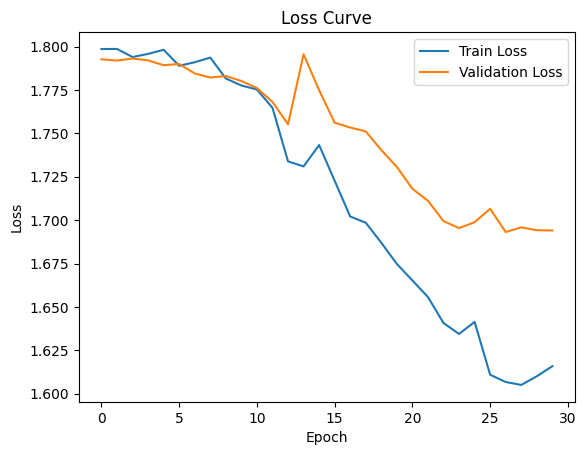

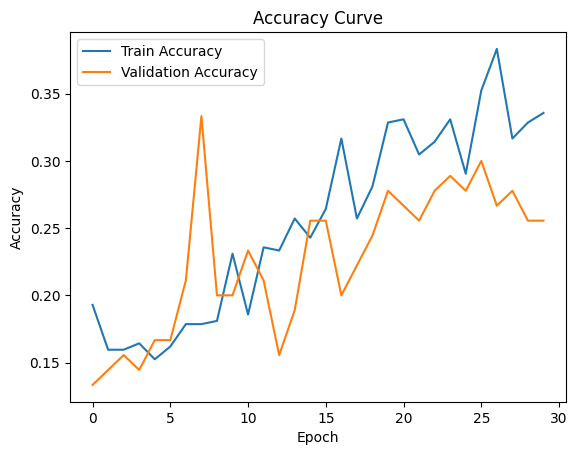

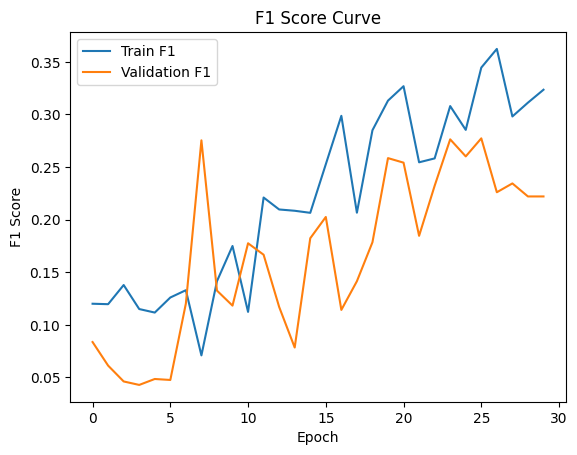

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7986,1.7927,0.1929,0.1333,0.1201,0.0837
1,2,1.7986,1.7920,0.1595,0.1444,0.1197,0.0613
2,3,1.7940,1.7931,0.1595,0.1556,0.1379,0.0462
3,4,1.7958,1.7920,0.1643,0.1444,0.1150,0.0429
4,5,1.7981,1.7893,0.1524,0.1667,0.1117,0.0485
5,6,1.7889,1.7900,0.1619,0.1667,0.1260,0.0476
6,7,1.7910,1.7845,0.1786,0.2111,0.1330,0.1202
7,8,1.7937,1.7822,0.1786,0.3333,0.0710,0.2754
8,9,1.7816,1.7830,0.1810,0.2000,0.1415,0.1326
9,10,1.7776,1.7802,0.2310,0.2000,0.1750,0.1183


In [6]:
aggr = aggr_list[i]
i += 1

experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# 'mean'

Epoch 1/30
Train Loss: 1.7941 | Validation Loss: 1.7921
Train Acc: 0.1905 | Validation Acc: 0.1778
Train F1: 0.1392 | Validation F1: 0.1345

Epoch 2/30
Train Loss: 1.7971 | Validation Loss: 1.7914
Train Acc: 0.1381 | Validation Acc: 0.1556
Train F1: 0.1036 | Validation F1: 0.0746

Epoch 3/30
Train Loss: 1.7944 | Validation Loss: 1.7908
Train Acc: 0.1571 | Validation Acc: 0.1667
Train F1: 0.1448 | Validation F1: 0.0835

Epoch 4/30
Train Loss: 1.7937 | Validation Loss: 1.7906
Train Acc: 0.1762 | Validation Acc: 0.1556
Train F1: 0.1428 | Validation F1: 0.0453

Epoch 5/30
Train Loss: 1.7951 | Validation Loss: 1.7893
Train Acc: 0.1595 | Validation Acc: 0.2111
Train F1: 0.1189 | Validation F1: 0.1045

Epoch 6/30
Train Loss: 1.7881 | Validation Loss: 1.7897
Train Acc: 0.1690 | Validation Acc: 0.1667
Train F1: 0.1399 | Validation F1: 0.0476

Epoch 7/30
Train Loss: 1.7903 | Validation Loss: 1.7877
Train Acc: 0.1952 | Validation Acc: 0.2556
Train F1: 0.1425 | Validation F1: 0.1780

Epoch 8/30
Tr

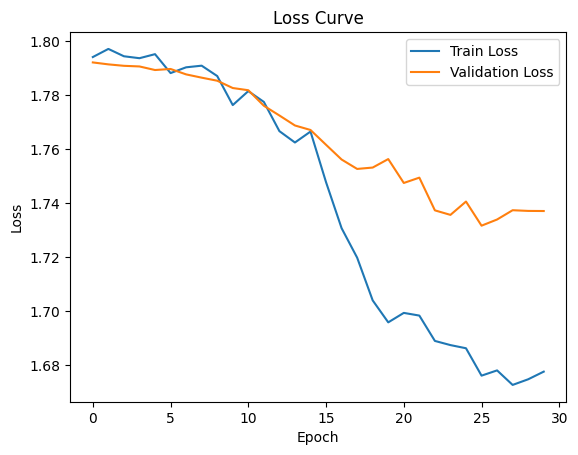

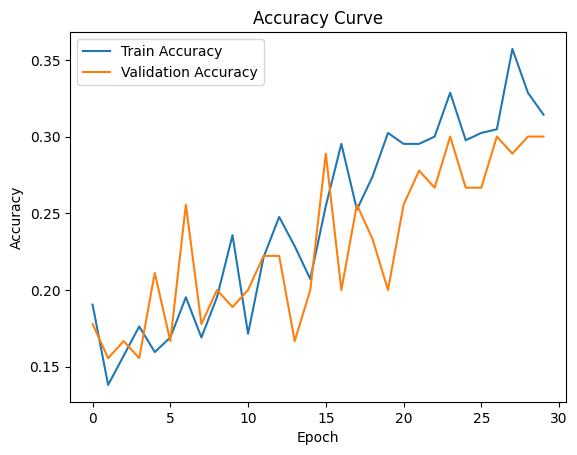

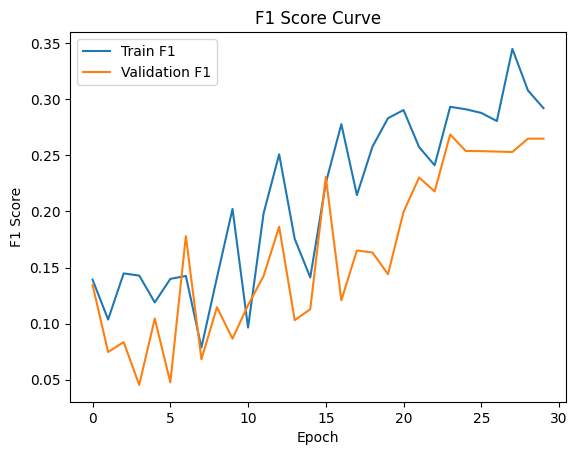

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7941,1.7921,0.1905,0.1778,0.1392,0.1345
1,2,1.7971,1.7914,0.1381,0.1556,0.1036,0.0746
2,3,1.7944,1.7908,0.1571,0.1667,0.1448,0.0835
3,4,1.7937,1.7906,0.1762,0.1556,0.1428,0.0453
4,5,1.7951,1.7893,0.1595,0.2111,0.1189,0.1045
5,6,1.7881,1.7897,0.1690,0.1667,0.1399,0.0476
6,7,1.7903,1.7877,0.1952,0.2556,0.1425,0.1780
7,8,1.7909,1.7865,0.1690,0.1778,0.0787,0.0682
8,9,1.7871,1.7853,0.1952,0.2000,0.1411,0.1146
9,10,1.7763,1.7826,0.2357,0.1889,0.2023,0.0865


In [7]:
aggr = aggr_list[i]
i += 1

experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# 'max'

/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1/30
Train Loss: 1.7956 | Validation Loss: 1.7924
Train Acc: 0.1810 | Validation Acc: 0.1333
Train F1: 0.1237 | Validation F1: 0.0908

Epoch 2/30
Train Loss: 1.7977 | Validation Loss: 1.7918
Train Acc: 0.1595 | Validation Acc: 0.1333
Train F1: 0.1176 | Validation F1: 0.0518



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3/30
Train Loss: 1.7944 | Validation Loss: 1.7919
Train Acc: 0.1619 | Validation Acc: 0.1556
Train F1: 0.1440 | Validation F1: 0.0734

Epoch 4/30
Train Loss: 1.7952 | Validation Loss: 1.7915
Train Acc: 0.1595 | Validation Acc: 0.1444
Train F1: 0.1158 | Validation F1: 0.0429



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5/30
Train Loss: 1.7971 | Validation Loss: 1.7897
Train Acc: 0.1571 | Validation Acc: 0.1667
Train F1: 0.1149 | Validation F1: 0.0490

Epoch 6/30
Train Loss: 1.7886 | Validation Loss: 1.7898
Train Acc: 0.1619 | Validation Acc: 0.1667
Train F1: 0.1197 | Validation F1: 0.0476



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7/30
Train Loss: 1.7917 | Validation Loss: 1.7872
Train Acc: 0.1881 | Validation Acc: 0.2889
Train F1: 0.1391 | Validation F1: 0.2163

Epoch 8/30
Train Loss: 1.7925 | Validation Loss: 1.7865
Train Acc: 0.1714 | Validation Acc: 0.1889
Train F1: 0.0731 | Validation F1: 0.0899



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9/30
Train Loss: 1.7874 | Validation Loss: 1.7855
Train Acc: 0.1762 | Validation Acc: 0.1778
Train F1: 0.1247 | Validation F1: 0.1037

Epoch 10/30
Train Loss: 1.7783 | Validation Loss: 1.7841
Train Acc: 0.2262 | Validation Acc: 0.2667
Train F1: 0.1759 | Validation F1: 0.1438



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 11/30
Train Loss: 1.7813 | Validation Loss: 1.7820
Train Acc: 0.1833 | Validation Acc: 0.2444
Train F1: 0.1027 | Validation F1: 0.1659

Epoch 12/30
Train Loss: 1.7757 | Validation Loss: 1.7777
Train Acc: 0.2429 | Validation Acc: 0.2222
Train F1: 0.2301 | Validation F1: 0.1481



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 13/30
Train Loss: 1.7649 | Validation Loss: 1.7744
Train Acc: 0.2333 | Validation Acc: 0.2444
Train F1: 0.2254 | Validation F1: 0.2078

Epoch 14/30
Train Loss: 1.7591 | Validation Loss: 1.7723
Train Acc: 0.2310 | Validation Acc: 0.1556
Train F1: 0.1808 | Validation F1: 0.1019



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 15/30
Train Loss: 1.7609 | Validation Loss: 1.7715
Train Acc: 0.2024 | Validation Acc: 0.2222
Train F1: 0.1465 | Validation F1: 0.1459

Epoch 16/30
Train Loss: 1.7438 | Validation Loss: 1.7644
Train Acc: 0.2476 | Validation Acc: 0.2333
Train F1: 0.2216 | Validation F1: 0.1914



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 17/30
Train Loss: 1.7212 | Validation Loss: 1.7608
Train Acc: 0.2976 | Validation Acc: 0.2111
Train F1: 0.2763 | Validation F1: 0.1323

Epoch 18/30
Train Loss: 1.7126 | Validation Loss: 1.7588
Train Acc: 0.2452 | Validation Acc: 0.2556
Train F1: 0.1854 | Validation F1: 0.1756



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 19/30
Train Loss: 1.7037 | Validation Loss: 1.7564
Train Acc: 0.2881 | Validation Acc: 0.2556
Train F1: 0.2771 | Validation F1: 0.1853

Epoch 20/30
Train Loss: 1.6942 | Validation Loss: 1.7541
Train Acc: 0.3167 | Validation Acc: 0.2556
Train F1: 0.2946 | Validation F1: 0.2094



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 21/30
Train Loss: 1.6910 | Validation Loss: 1.7491
Train Acc: 0.3000 | Validation Acc: 0.2556
Train F1: 0.2882 | Validation F1: 0.2070

Epoch 22/30
Train Loss: 1.6916 | Validation Loss: 1.7480
Train Acc: 0.2833 | Validation Acc: 0.2333
Train F1: 0.2415 | Validation F1: 0.1631



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 23/30
Train Loss: 1.6838 | Validation Loss: 1.7435
Train Acc: 0.3048 | Validation Acc: 0.2333
Train F1: 0.2539 | Validation F1: 0.1697

Epoch 24/30
Train Loss: 1.6797 | Validation Loss: 1.7407
Train Acc: 0.3238 | Validation Acc: 0.2333
Train F1: 0.2892 | Validation F1: 0.1623



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 25/30
Train Loss: 1.6763 | Validation Loss: 1.7398
Train Acc: 0.3000 | Validation Acc: 0.2889
Train F1: 0.3017 | Validation F1: 0.2530

Epoch 26/30
Train Loss: 1.6662 | Validation Loss: 1.7389
Train Acc: 0.3333 | Validation Acc: 0.2667
Train F1: 0.3311 | Validation F1: 0.2146



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 27/30
Train Loss: 1.6637 | Validation Loss: 1.7405
Train Acc: 0.3286 | Validation Acc: 0.2444
Train F1: 0.3078 | Validation F1: 0.1837

Epoch 28/30
Train Loss: 1.6663 | Validation Loss: 1.7422
Train Acc: 0.3167 | Validation Acc: 0.2333
Train F1: 0.3025 | Validation F1: 0.1697



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 29/30
Train Loss: 1.6664 | Validation Loss: 1.7419
Train Acc: 0.3310 | Validation Acc: 0.2333
Train F1: 0.3170 | Validation F1: 0.1697

Epoch 30/30
Train Loss: 1.6679 | Validation Loss: 1.7419
Train Acc: 0.3262 | Validation Acc: 0.2333
Train F1: 0.3154 | Validation F1: 0.1697



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


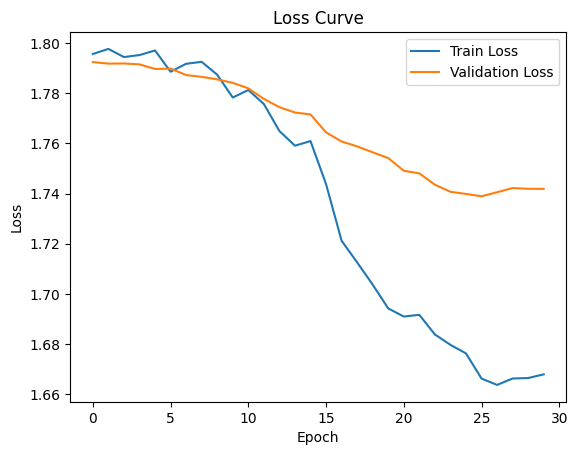

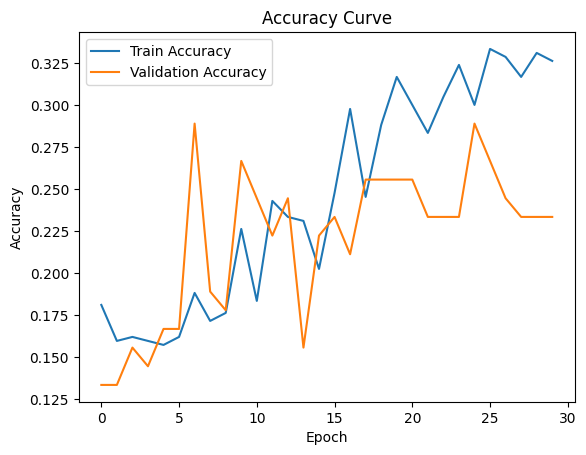

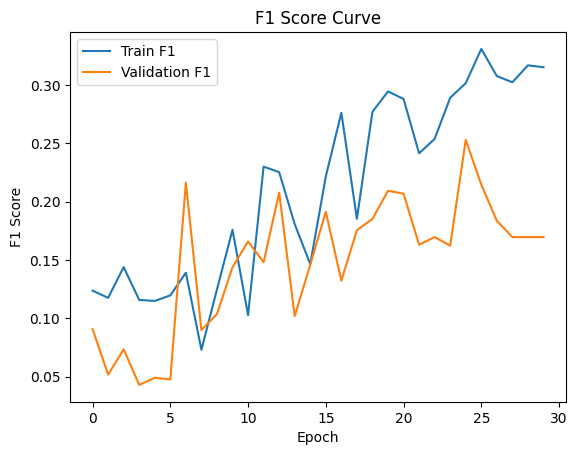

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.7956,1.7924,0.1810,0.1333,0.1237,0.0908
1,2,1.7977,1.7918,0.1595,0.1333,0.1176,0.0518
2,3,1.7944,1.7919,0.1619,0.1556,0.1440,0.0734
3,4,1.7952,1.7915,0.1595,0.1444,0.1158,0.0429
4,5,1.7971,1.7897,0.1571,0.1667,0.1149,0.0490
5,6,1.7886,1.7898,0.1619,0.1667,0.1197,0.0476
6,7,1.7917,1.7872,0.1881,0.2889,0.1391,0.2163
7,8,1.7925,1.7865,0.1714,0.1889,0.0731,0.0899
8,9,1.7874,1.7855,0.1762,0.1778,0.1247,0.1037
9,10,1.7783,1.7841,0.2262,0.2667,0.1759,0.1438


In [8]:
aggr = aggr_list[i]
i += 1

experiment_name = f"ENZYMES-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)